### 문서 유사도 측정 방법 – 코사인 유사도

In [1]:
import numpy as np
v1, v2 = np.array([2,1]), np.array([1,2])
np.square(v1), sum(np.square(v1)), np.sqrt(sum(np.square(v1)))

(array([4, 1], dtype=int32), 5, 2.23606797749979)

In [2]:
np.dot(v1, v2) / (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))

0.7999999999999998

In [3]:
def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm     
    
    return similarity

In [4]:
cos_similarity(v1, v2)

0.7999999999999998

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tvect = TfidfVectorizer()
feature = tvect.fit_transform(doc_list)
print(feature.shape)

(3, 18)


In [6]:
feature[0].toarray()[0]

array([0.4155636 , 0.        , 0.4155636 , 0.        , 0.        ,
       0.        , 0.24543856, 0.        , 0.24543856, 0.        ,
       0.        , 0.        , 0.        , 0.4155636 , 0.24543856,
       0.49087711, 0.        , 0.24543856])

In [7]:
cos_similarity(feature[0].toarray()[0], feature[1].toarray()[0])

0.4020775821495014

In [9]:
# 모든 문장의 feature vector 추출
vect1 = feature[0].toarray()[0]
vect2 = feature[1].toarray()[0]
vect3 = feature[2].toarray()[0]

#첫번째 문장과 두번째 문장의 feature vector로 두개 문장의 Cosine 유사도 추출
print(f'문장 1, 문장 2 Cosine 유사도: {cos_similarity(vect1, vect2):.4f}')

문장 1, 문장 2 Cosine 유사도: 0.4021


In [10]:
print(f'문장 1, 문장 3 Cosine 유사도: {cos_similarity(vect1, vect3):.4f}')
print(f'문장 2, 문장 3 Cosine 유사도: {cos_similarity(vect2, vect3):.4f}')

문장 1, 문장 3 Cosine 유사도: 0.4043
문장 2, 문장 3 Cosine 유사도: 0.4565


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_pair = cosine_similarity(feature[0], feature)
print(similarity_pair)

[[1.         0.40207758 0.40425045]]


In [13]:
similarity_pair = cosine_similarity(feature, feature)
print(similarity_pair)
print('shape:', similarity_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


### Opinion Review 데이터 셋을 이용한 문서 유사도 측정

In [9]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [17]:
from nltk import word_tokenize

def simple_tokenizer(text):
    word_list = word_tokenize(text.lower())
    return [word for word in word_list if len(word) > 2]

In [20]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = 'OpinosisDataset1.0/topics'
filename_list = []
opinion_text = []
for file_ in glob.glob(os.path.join(path, "*.data")):
    with open(file_, encoding='latin1') as f:
        texts = f.read()
    # 절대경로로 주어진 file 명을 가공. 만일 Linux에서 수행시에는 아래 \\를 / 변경. 맨 마지막 .data 확장자도 제거
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    #파일명 리스트와 파일내용 리스트에 파일명과 파일 내용을 추가. 
    filename_list.append(filename)
    opinion_text.append(texts)
    
df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
tvect = TfidfVectorizer(tokenizer=simple_tokenizer, stop_words='english', 
                        ngram_range=(1,2), min_df=0.05, max_df=0.85)
feature_vect = tvect.fit_transform(df.opinion_text)
# 3개의 집합으로 군집화 
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
df['cluster_label'] = cluster_label

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=0인 데이터는 호텔로 클러스터링된 데이터임. DataFrame에서 해당 Index를 추출
hotel_indexes = df[df['cluster_label']==0].index
print('호텔로 클러스터링 된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 클러스터링된 데이터 중 첫번째 문서를 추출하여 파일명 표시.  
comparison_docname = df.iloc[hotel_indexes[0]]['filename']
print(f'##### 비교 기준 문서명 {comparison_docname}와 타 문서 유사도######')

''' df에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 클러스터링된 feature_vect 추출 
이를 이용하여 호텔로 클러스터링된 문서 중 첫번째 문서와 다른 문서간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 클러스터링 된 문서들의 DataFrame Index: Int64Index([1, 13, 14, 15, 20, 21, 24, 27, 28, 30, 31, 32, 38, 39, 40, 45, 46], dtype='int64')
##### 비교 기준 문서명 bathroom_bestwestern_hotel_sfo와 타 문서 유사도######
[[1.         0.03950499 0.05053449 0.06150525 0.05685307 0.05599072
  0.0320052  0.01997832 0.10782179 0.24817652 0.19257054 0.48108337
  0.1056082  0.13093222 0.12852642 0.08746969 0.06831609]]


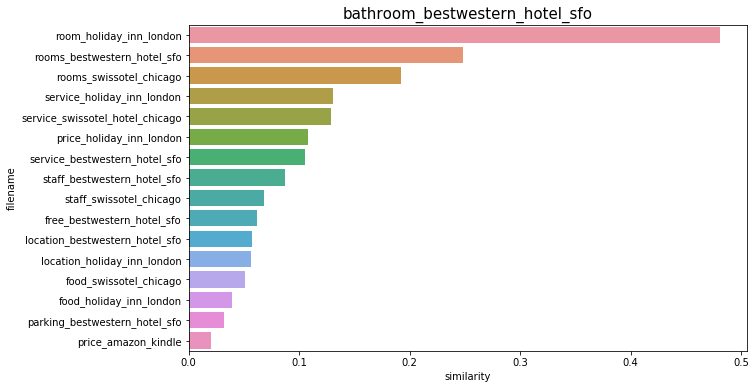

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# argsort()를 이용하여 앞예제의 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 반환하되 자기 자신은 제외. 
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재 정렬. 
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 Index와 유사도값을 이용하여 파일명과 유사도값을 Seaborn 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

plt.figure(figsize=(10,6))
sns.barplot(x='similarity', y='filename', data=hotel_1_sim_df)
plt.title(comparison_docname, fontsize=15)
plt.show()